In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline

### **Importing Data**

Here we import data from XYZ company

In [33]:
df = pd.read_csv('data/xyz.csv')
df.head()

,Date,PX_LAST,DCF_Proxy,Comps_Proxy,Precedents_Proxy
0,1995-03-31,48.855392,39.546710,51.710810,43.143860
1,1995-06-30,52.294634,50.509202,NaN,53.833217
2,1995-09-30,50.272239,57.376801,48.394056,64.512879
3,1995-12-31,52.605279,48.284345,52.106131,52.050271
4,1996-03-31,49.567595,59.092681,48.998416,52.221209


### **Data Explanation**

The stock price data is synthetically generated for a fictional XYZ company in the Tech sector. I took a look at multiple peers and assumed XYZ’s underlying share-price trajectory would be similar to “peer” price series with steady drifts and moderate volatility. 

<p>The purpose of the data is to fully test the functionality of the model. Below are the data transformations and edge cases we incorporated into the 120-quarter XYZ dataset to mirror realistic market conditions:</p>

<ul>
  <li><strong>High-frequency noise:</strong> added Gaussian noise (~±5% volatility) to <code>PX_LAST</code></li>
  <li><strong>Sentiment shocks (3 total):</strong> isolated ±20% jumps in <code>PX_LAST</code> to simulate major news or earnings surprises</li>
  <li><strong>Forecast errors (±10% σ):</strong> per-quarter multiplicative deviations applied to each proxy series (<code>DCF_Proxy</code>, <code>Comps_Proxy</code>, <code>Precedents_Proxy</code>)</li>
  <li><strong>Timing mismatches:</strong> 10% of quarters lagged by 1 quarter and 5% lagged by 2 quarters for each proxy to represent reporting delays</li>
  <li><strong>Staleness events:</strong> one 3-quarter freeze per proxy to mimic delayed analyst updates</li>
  <li><strong>Missing values (~5% per proxy):</strong> randomly blanked entries in each proxy column to reflect data gaps</li>
</ul>

For simplicity, I assumed a readily available proxy for each valuation method. In practice, you’ll need to collect and engineer these proxy features yourself:

<ul>
  <li><strong>Comps &amp; Precedents:</strong>
    <ol>
      <li>Select relevant peer group and past transactions</li>
      <li>Use the Bloomberg Terminal to pull each peer’s and deal’s EV/EBITDA (or other multiples) on a quarterly basis</li>
      <li>Convert multiples into per-share values by multiplying by the company’s market cap (<code>CUR_MKT_CAP</code>) and dividing by shares outstanding (<code>EQY_SH_OUT</code>)</li>
    </ol>
  </li>
  <li><strong>DCF:</strong> Reference the <a href="https://github.com/scfengv/Stock-Valuation">scfengv/Stock-Valuation</a> repo to generate DCF-based target prices and use those as your DCF proxy.</li>
</ul>

### **Exploratory Data Analysis**

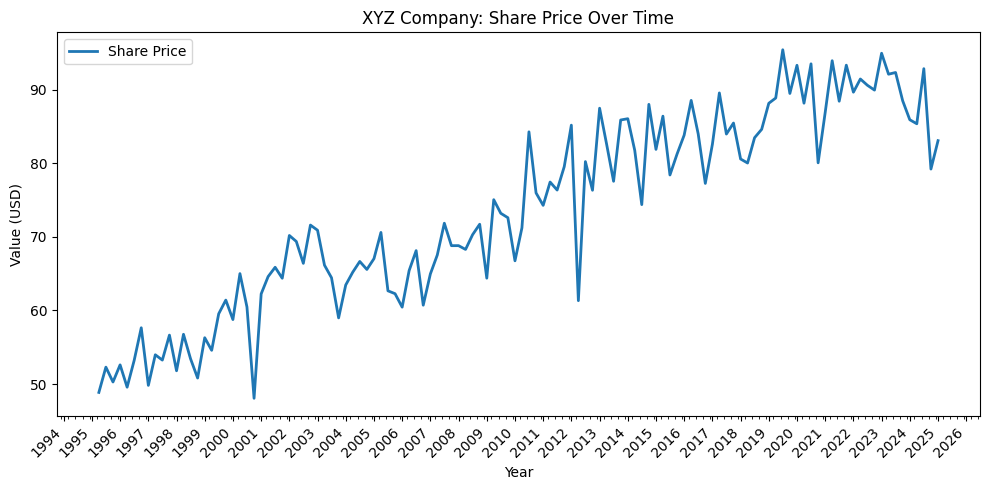

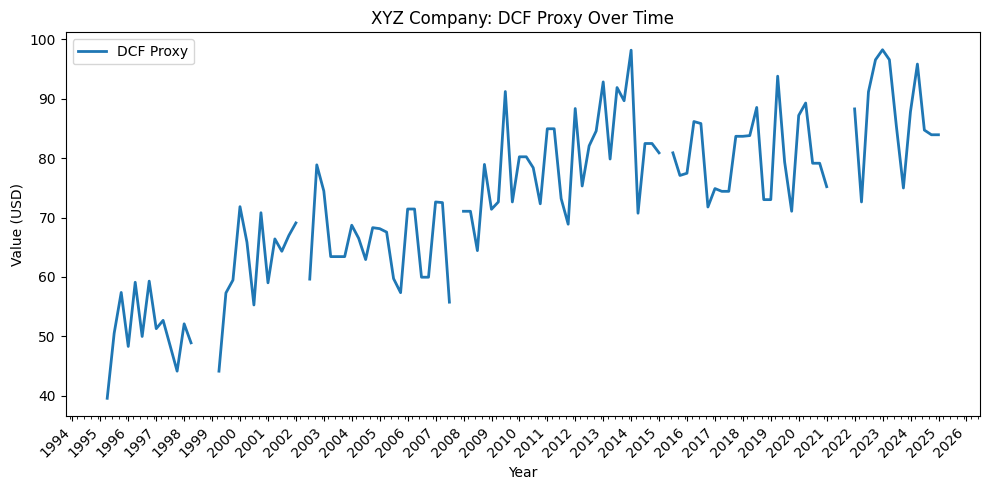

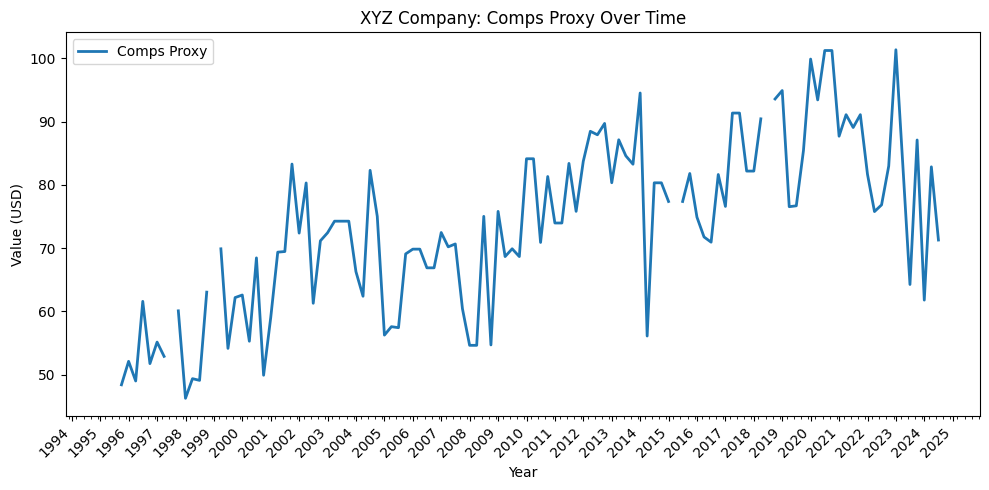

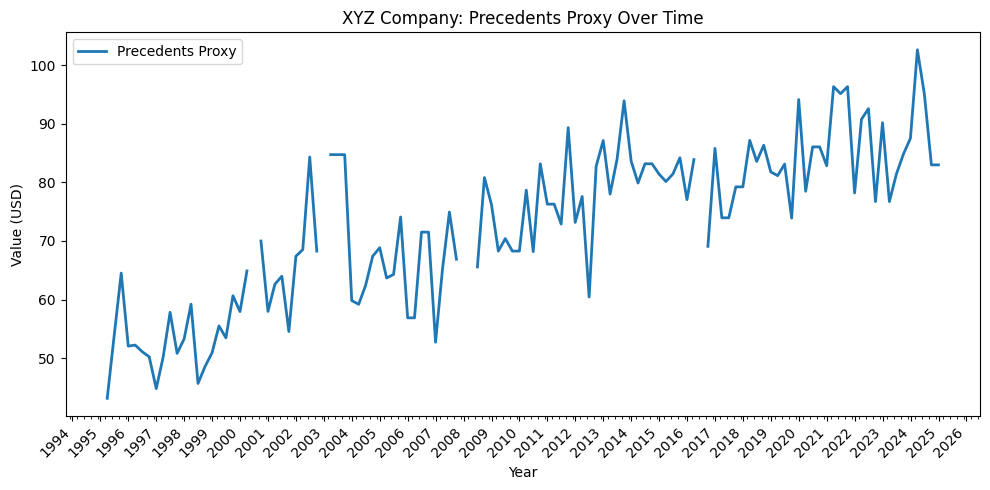

In [34]:
# 1. Ensure Date is datetime and sorted
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# 2. Define the columns you want to plot and friendly titles
cols = {
    'PX_LAST': 'Share Price',
    'DCF_Proxy': 'DCF Proxy',
    'Comps_Proxy': 'Comps Proxy',
    'Precedents_Proxy': 'Precedents Proxy'
}

# 3. Loop to create 4 separate plots
for col, title in cols.items():
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # plot the series
    ax.plot(
        df['Date'],
        df[col],
        linewidth=2,
        marker='',
        label=title
    )
    
    # format x-axis
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(3,6,9,12)))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # labels, title, legend
    ax.set_xlabel('Year')
    ax.set_ylabel('Value (USD)')
    ax.set_title(f'XYZ Company: {title} Over Time')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

This snippet generates the time series for the actual share price alongside each valuation proxy (DCF, comps, precedents), enabling us to directly measure and visualize the per-quarter deviation of each method from the true market price—and to analyze how those gaps evolve across different market regimes.

In [35]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              120 non-null    datetime64[ns]
 1   PX_LAST           120 non-null    float64       
 2   DCF_Proxy         113 non-null    float64       
 3   Comps_Proxy       113 non-null    float64       
 4   Precedents_Proxy  115 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 4.8 KB
None
                      Date     PX_LAST   DCF_Proxy  Comps_Proxy  \
count                  120  120.000000  113.000000   113.000000   
mean   2010-02-13 18:00:00   73.402723   72.768081    73.412907   
min    1995-03-31 00:00:00   48.056194   39.546710    46.261938   
25%    2002-09-07 00:00:00   64.154721   63.416345    62.593801   
50%    2010-02-14 00:00:00   72.921012   72.626186    74.270089   
75%    2017-07-23 00:00:00   85.258539   83.686031  

<p>This function gives you a quick overview of your dataset’s health and characteristics:</p>
<ul>
  <li><strong>Completeness:</strong> How many values are available versus missing for each column.</li>
  <li><strong>Central tendency:</strong> The average level of each metric compared to the share price.</li>
  <li><strong>Dispersion:</strong> The variability and range (std, min/max) showing how stable or extreme each series is.</li>
  <li><strong>Distribution shape:</strong> The relationship between mean and median indicating skew or heavy tails.</li>
</ul>


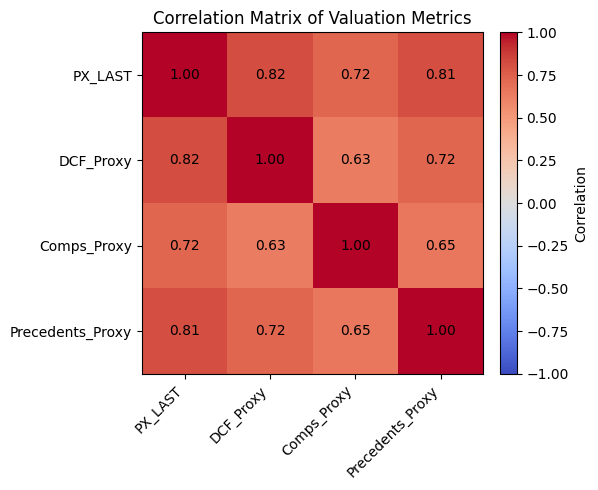

In [36]:
# 2. Compute the correlation matrix on the relevant columns
cols = ["PX_LAST", "DCF_Proxy", "Comps_Proxy", "Precedents_Proxy"]
corr = df[cols].corr()

# 3. Plot the heatmap
fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.imshow(corr, vmin=-1, vmax=1, cmap="coolwarm")

# 4. Ticks & labels
ax.set_xticks(np.arange(len(cols)))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(cols)
ax.set_yticklabels(cols)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# 5. Annotate correlation values
for i in range(len(cols)):
    for j in range(len(cols)):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", color="black")

# 6. Colorbar & title
fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04, label="Correlation")
ax.set_title("Correlation Matrix of Valuation Metrics")

plt.tight_layout()
plt.show()

<p>The correlation matrix shows how closely each valuation proxy tracks the actual share price:</p>
<ul>
  <li><strong>High correlation (|r| ≥ 0.8):</strong> Proxy moves in tandem with price, suggesting strong alignment.</li>
  <li><strong>Low correlation (0.3 ≤ |r|):</li></strong> Proxy diverges from price, indicating it captures different signals or noise.</li>
  <li><strong>Inter-proxy correlations:</strong> Reveal whether valuation methods agree with each other as well as with market pricing.</li>
</ul>


### **Preprocessing & Transformations**

In [37]:
# 1) Load & sort by date
df = df.sort_values("Date").reset_index(drop=True)

# 2) Compute the 4-quarter rolling mean (causal: only t, t-1, t-2, t-3)
df["PX_LAST_smooth"] = (
    df["PX_LAST"]
      .rolling(window=4, min_periods=1)
      .mean()
)

We compute a 4-quarter moving average of the target to dampen short-term volatility, allowing the model to learn the underlying trend without being distracted by random noise.

In [42]:
proxy_cols = ['DCF_Proxy', 'Comps_Proxy', 'Precedents_Proxy']

for col in proxy_cols:
    # flag repeats from 1-quarter lag or 2-quarter lag
    mask_1 = df[col] == df[col].shift(1)
    mask_2 = df[col] == df[col].shift(2)
    mask   = mask_1 | mask_2
    
    # blank out all such repeats
    df.loc[mask, col] = np.nan

Here, we blank out any proxy value that exactly repeats its 1- or 2-quarter ago figure—because an unchanged number almost certainly reflects a stale update rather than a genuine new estimate—so that it’ll be treated as missing.

For each proxy (DCF, Comps, Precedent) we generate three features—on‐time, one‐quarter lag, two‐quarter lag—to ensure late information is available. Since we are only filling each row with past information, we are effectively not breaking the golden rule.

We would need to split the data again with the same seed so that the new splitted data carries the new features. 

In [30]:
X_train = train_df.drop(columns = ['PX_LAST', 'Date'])
y_train = train_df['PX_LAST']

X_test = test_df.drop(columns = ['PX_LAST', 'Date'])
y_test = test_df['PX_LAST']

In [25]:
model = Ridge()